# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2020-02-05 04:36:06,175 INFO    : root         : Using LISA logging configuration:
2020-02-05 04:36:06,178 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2019-11-23 06:04:27,804 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2019-11-23 06:04:27,818 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnQTAxNUYvQTAxNUZTSzVfUU9TXzE5MTEyMV8xOTExMjFfMTE1MzU4X2hlbGxvd29ybGQnLCBsYXlvdXTigKY=


## Run cells

Please select over two of systrace files and press the run button to execute below cells.
You could see the some graphs of group1 or gruop2 to compare.

In [40]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [41]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select two groups of systrace to analysis.

## Read Files

In [42]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [14]:
group1.run()
group2.run()

Parsing GIGEUSG2_POS_190701_190701_144926_gallery.html - 153560 lines are Ok
Parsing GIGEUSG2_POS_190701_190701_154437_gallery.html - 155031 lines are Ok
Parsing GIGEUSG2_POS_190701_190701_135024_gallery.html - 144883 lines are Ok
Parsing GIGEUSH8_QOS_190829_190828_222304_gallery.html - 149632 lines are Ok
Parsing GIGEUSH8_QOS_190829_190828_211640_gallery.html - 149044 lines are Ok
Parsing GIGEUSH8_QOS_190829_190828_232929_gallery.html - 169323 lines are Ok


## Analysis

### The timing of marking data

The operation times of each trace_mark_filters tags of systrac.

In [15]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1569.0,NaN,1.805,0.014,NaN,NaN,NaN,NaN,NaN
9634.0,0.003,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1243.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,212.52
1796.0,0.009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8359.0,NaN,6.322,NaN,NaN,NaN,NaN,NaN,NaN
9929.0,NaN,NaN,NaN,41.613,NaN,5.931,NaN,NaN
1570.0,NaN,0.585,0.630,NaN,NaN,NaN,NaN,NaN
3633.0,1.892,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2386.0,0.162,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1793.0,0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1570.0,NaN,1.101,0.027,NaN,NaN,NaN,NaN,NaN
1851.0,NaN,0.096,0.064,NaN,NaN,NaN,NaN,NaN
8454.0,0.580,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3142.0,NaN,0.263,7.580,NaN,NaN,NaN,NaN,NaN
2305.0,0.127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9913.0,NaN,NaN,NaN,174.491,NaN,6.198,NaN,NaN
9895.0,NaN,NaN,NaN,37.059,NaN,6.053,NaN,NaN
1265.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.693


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1568.0,NaN,0.624,1.012,NaN,NaN,NaN,NaN,NaN
1803.0,0.005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8420.0,0.443,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9542.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9809.0,NaN,NaN,NaN,51.145,NaN,5.998,NaN,NaN
1256.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216.495
3627.0,0.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3119.0,NaN,2.623,0.620,NaN,NaN,NaN,NaN,NaN
9800.0,11.084,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12632.0,NaN,NaN,NaN,38.438,NaN,5.818,NaN,NaN
1541.0,NaN,11.574,6.131,NaN,NaN,NaN,NaN,NaN
2566.0,NaN,1.374,0.054,NaN,NaN,NaN,NaN,NaN
12721.0,NaN,NaN,NaN,191.490,NaN,13.269,NaN,NaN
4553.0,NaN,4.721,NaN,NaN,NaN,NaN,NaN,NaN
2058.0,NaN,0.063,0.057,NaN,NaN,NaN,NaN,NaN
2765.0,0.163,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10798.0,NaN,6.558,NaN,NaN,NaN,NaN,NaN,NaN
4751.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12682.0,NaN,NaN,NaN,225.731,NaN,11.164,NaN,NaN
10788.0,NaN,8.398,NaN,NaN,NaN,NaN,NaN,NaN
5734.0,NaN,42.898,31.092,NaN,73.525,NaN,10.79,NaN
12593.0,NaN,NaN,NaN,38.013,NaN,5.566,NaN,NaN
3645.0,2.878,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12615.0,NaN,NaN,NaN,133.135,NaN,6.832,NaN,NaN
12562.0,25.117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12175.0,0.020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10960.0,1.035,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12160.0,0.028,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4547.0,NaN,5.658,NaN,NaN,NaN,NaN,NaN,NaN
5636.0,NaN,31.771,25.731,NaN,79.096,NaN,27.436,NaN
1541.0,NaN,0.995,0.006,NaN,NaN,NaN,NaN,NaN
1542.0,NaN,1.799,0.866,NaN,NaN,NaN,NaN,NaN
2572.0,NaN,1.305,0.044,NaN,NaN,NaN,NaN,NaN
2061.0,NaN,0.062,0.057,NaN,NaN,NaN,NaN,NaN
2670.0,0.184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12625.0,NaN,NaN,NaN,135.832,NaN,25.442,NaN,NaN


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [17]:
list_of_df = group1.get_marking_time()
count1 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        count1 += 1
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = DataFrame(sum_df1.sum(axis=0)).swapaxes("index", "columns") 
    sum_df1.index = [group1.title]
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1)
except:
    print("No launching time")

list_of_df = group2.get_marking_time()
count2 = 0

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        count2 += 1
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = DataFrame(sum_df2.sum()).swapaxes("index", "columns") 
    sum_df2.index = [group2.title]
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1)

    pd.concat([sum_df1 * 1000 / count1, sum_df2 * 1000 / count2])
except:
    print("No launching time")

### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [18]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222... time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                               time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                              Choreographer #0  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... time                                 13.559   
                                                   RUNNING                               2.225   
                                                   RUNNABLE                              0.053   
                                                   SLEEPING                             11.281   
                                                   UNINTERUPTIBLE_SLEEP                  0.000   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             0.000   
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222... time                                 37.150   
                                                   RUNNING                               3.570   
                                                   RUNNABLE                              1.986   
                                                   SLEEPING                             31.076   
                                                   UNINTERUPTIBLE_SLEEP                  0.518   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             0.000   
DIFF                                               time                                -23.591   
                                                   RUNNING                              -1.345   
                                                   RUNNABLE                             -1.933   
                                                   SLEEPING                            -19.795   
                                                   UNINTERUPTIBLE_SLEEP                 -0.518   
                                                   UNINTERUPTIBLE_SLEEP(I/O)             0.000   

                                                                              Choreographer #1  \
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144... time                                 22.618   
                                                   RUNNING                               9.924   
                                                   RUNNABLE                              0.289   
                                                   SLEEPING               

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery,time,0,13.559,22.618,42.143,55.229,16.206,19.361,0
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery,time,0,37.150,27.283,0.000,78.375,0.000,23.304,0
DIFF,time,0,-23.591,-4.665,42.143,-23.146,16.206,-3.943,0


### Processing time of setSurface

In [18]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [20]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,2,3,avg
GIGEUSG2_Gallery_GIGEUSG2_POS_190701_190701_144926_gallery,16.633,15.251,11.084,14.322667
GIGEUSH8_Gallery_GIGEUSH8_QOS_190829_190828_222304_gallery,19.422,25.117,16.386,20.308333


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [50]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

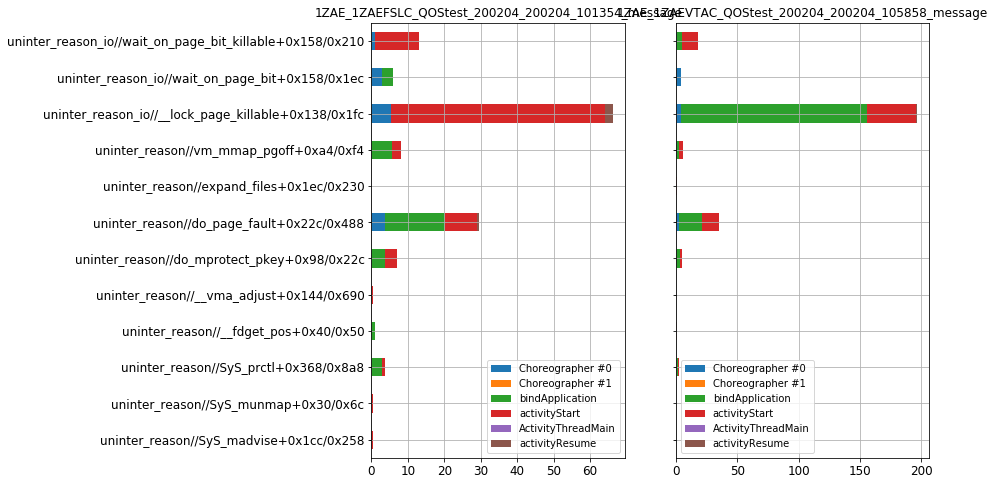

In [21]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)

df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

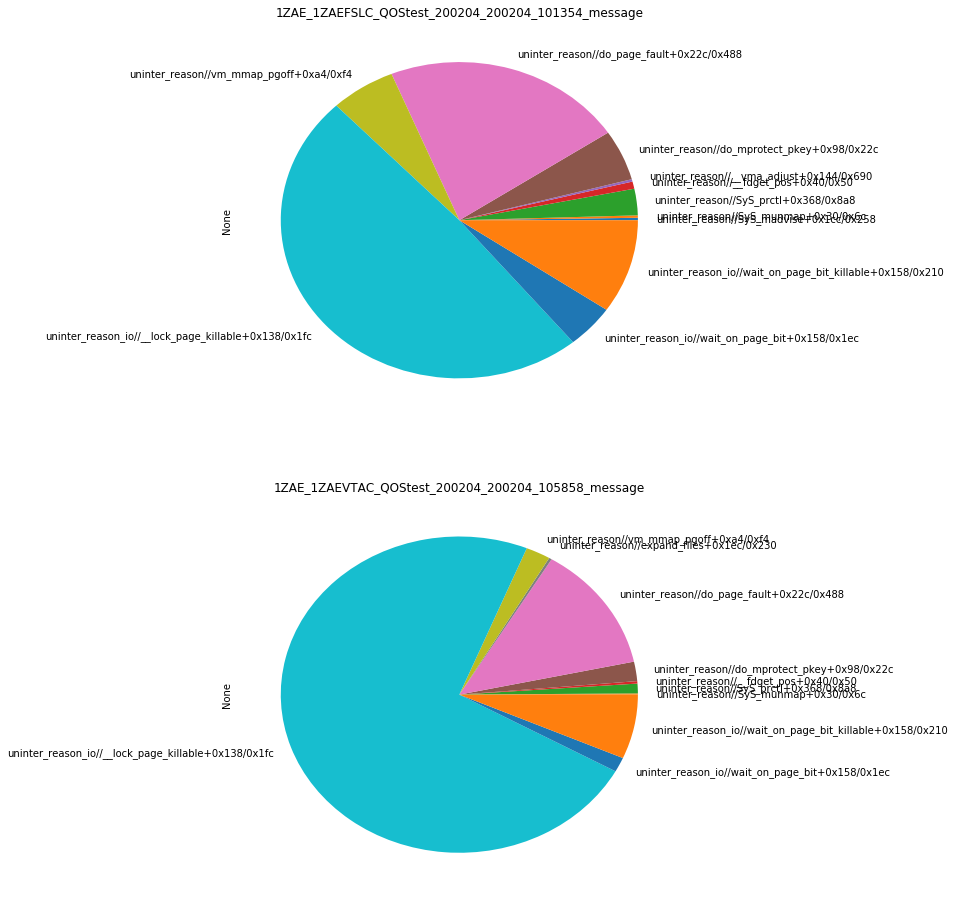

In [22]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

The number of count in each reason of uninterruptible sleep.

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

Choreographer #0  \
TEST_TEST1_POS_191010_191010_192902_contact     core0                 2   
                                                core1                 0   
                                                core2                 1   
                                                core3                 0   
                                                core4                 1   
                                                core5                 1   
                                                core6                14   
                                                core7                20   
TEST_TEST2TTTT_POS_191010_191010_231835_contact core0                 0   
                                                core1                 0   
                                                core2                 1   
                                                core3                 0   
                                                core4                 1   
                                                core5                 0   
                                                core6                 7   
                                                core7                27   

                                                       Choreographer #1  \
TEST_TEST1_POS_191010_191010_192902_contact     core0                 0   
                                                core1                 0   
                                                core2                 0   
                                                core3                 0   
                                                core4                 0   
                                                core5                 0   
                                                core6                 0   
                                                core7                 5   
TEST_TEST2TTTT_POS_191010_191010_231835_contact core0                 0   
                                                core1                 0   
                                                core2                 0   
                                                core3                 0   
                                                core4                 0   
                                                core5                 0   
                                                core6                 0   
                                                core7                 5   

                                                       activityStart  \
TEST_TEST1_POS_191010_191010_192902_contact     core0             29   
                                                core1             21   
                                                core2             17   
                                                core3             15   
                                                core4             23   
                                                core5             31   
                                                core6             62   
                                                core7             81   
TEST_TEST2TTTT_POS_191010_191010_231835_contact core0             19   
                                                core1              9   
                                                core2             14   
                                                core3              8   
                                                core4             25   
                                                core5             21   
                                                core6             47   
                                                core7             94   

                                                       activityResume  
TEST_TEST1_POS_191010_191010_192902_contact     core0               0  
                                                core1               0  
                                                core2         

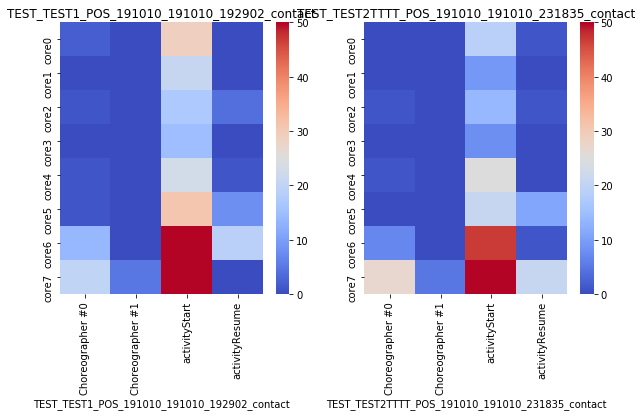

In [23]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [24]:
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,3,0,45,65,0,10,NaN
core1,NaN,10,1,7,61,0,3,NaN
core2,NaN,16,2,35,29,0,10,NaN
core3,NaN,5,0,42,49,4,0,NaN
core4,NaN,0,0,9,2,0,1,NaN
core5,NaN,0,0,8,1,0,0,NaN
core6,NaN,0,0,2,2,0,0,NaN
core7,NaN,0,0,5,0,0,3,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,12,1,30,44,0,7,NaN
core1,NaN,6,0,40,70,1,5,NaN
core2,NaN,10,0,8,44,3,6,NaN
core3,NaN,2,2,25,49,0,11,NaN
core4,NaN,0,0,9,1,0,0,NaN
core5,NaN,0,0,11,1,0,0,NaN
core6,NaN,0,0,4,0,0,0,NaN
core7,NaN,0,0,7,1,0,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,9,1,19,57,4,4,NaN
core1,NaN,5,0,27,53,0,5,NaN
core2,NaN,11,0,21,42,0,13,NaN
core3,NaN,3,2,27,47,0,1,NaN
core4,NaN,0,1,5,2,0,0,NaN
core5,NaN,0,0,1,1,0,0,NaN
core6,NaN,0,0,2,1,0,0,NaN
core7,NaN,0,0,1,1,0,0,NaN


In [25]:
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,3,0,73,47,0,10,NaN
core1,NaN,17,0,65,47,1,4,NaN
core2,NaN,2,6,58,38,2,8,NaN
core3,NaN,9,0,87,51,1,3,NaN
core4,NaN,0,0,4,7,0,0,NaN
core5,NaN,0,0,2,5,0,0,NaN
core6,NaN,0,0,2,5,0,2,NaN
core7,NaN,0,0,2,3,0,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,1,3,68,54,1,7,NaN
core1,NaN,3,0,69,33,0,9,NaN
core2,NaN,12,2,80,59,3,4,NaN
core3,NaN,6,0,55,57,0,0,NaN
core4,NaN,0,0,11,6,0,0,NaN
core5,NaN,0,0,5,2,0,0,NaN
core6,NaN,0,0,4,0,0,0,NaN
core7,NaN,0,0,6,3,0,0,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,6,6,65,32,0,9,NaN
core1,NaN,15,0,78,64,0,19,NaN
core2,NaN,12,2,75,44,3,0,NaN
core3,NaN,6,0,70,33,1,9,NaN
core4,NaN,0,0,13,11,0,0,NaN
core5,NaN,0,0,5,8,0,0,NaN
core6,NaN,0,0,2,2,0,0,NaN
core7,NaN,0,0,0,2,0,0,NaN


In [56]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [27]:
display(GetCoreStats(group1))

0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    V  I  R  I  I  I  I  I         0  332.536929
                   1    V  I  I  I  I  I  I  I         0  332.537501
                   2    V  I  I  I  I  I  I  I         0  332.545747
                   3    R  I  I  V  I  I  I  I         3  332.551935
bindApplication    0    I  I  R  V  I  I  I  I         3  332.553157
                   1    I  I  V  I  I  I  I  I         2  332.553257
                   2    I  I  R  V  I  I  I  I         3  332.553416
                   3    I  V  I  I  I  I  I  I         1  332.553986
                   4    I  I  I  V  I  I  I  I         3  332.554085
                   5    I  I  I  V  I  I  I  I         3  332.554330
                   6    I  I  I  V  I  I  I  I         3  332.561655
                   7    R  I  I  V  I  I  I  I         3  332.562030
                   8    V  I  I  R  I  I  I  I         0  332.564718
                   9    V  I  I  I  I  I  I  I         0  332.565124
                   10   V  R  I  R  I  I  I  I         0  332.600096
                   11   V  R  I  I  I  I  I  I         0  332.603622
                   12   V  I  R  I  I  I  I  I         0  332.608702
                   13   I  I  V  I  I  I  I  I         2  332.612169
                   14   V  R  I  I  I  I  I  I         0  332.612273
                   15   V  I  I  I  I  I  I  I         0  332.613159
                   16   V  R  I  I  I  I  I  I         0  332.613487
                   17   I  V  I  I  I  I  I  I         1  332.613628
                   18   V  I  I  I  I  I  I  I         0  332.613985
                   19   I  V  I  I  I  I  I  I         1  332.614859
                   20   V  I  I  I  I  I  I  I         0  332.614908
                   21   I  V  R  I  I  I  I  I         1  332.616354
                   22   V  R  I  I  I  I  I  I         0  332.617870
                   23   V  R  I  I  I  I  I  I         0  332.618158
                   24   V  R  I  R  I  I  I  I         0  332.618392
                   25   I  V  I  I  I  I  I  I         1  332.619342
                   26   I  I  I  V  I  I  I  I         3  332.619876
                   27   I  I  I  V  R  I  I  I         3  332.620137
                   28   I  I  I  V  I  I  I  I         3  332.620357
                   29   I  V  I  I  I  I  I  I         1  332.620827
                   30   I  V  I  I  I  I  I  I         1  332.621246
                   31   I  I  I  V  I  I  I  I         3  332.621715
                   32   I  V  I  R  I  I  I  I         1  332.622403
                   33   I  R  V  I  I  I  I  I         2  332.630098
                   34   I  I  V  R  I  I  I  I         2  332.632572
                   35   R  V  I  I  I  I  I  I         1  332.644409
                   36   R  V  I  I  I  I  I  I         1  332.644494
                   37   R  V  I  I  I  I  I  I         1  332.647366
                   38   R  V  I  I  I  I  I  I         1  332.648046
                   39   R  I  V  I  I  I  I  I         2  332.648349
                   40   R  V  I  I  I  I  I  I         1  332.648406
                   41   R  I  V  I  I  I  I  I         2  332.648543
                   42   R  V  I  I  I  I  I  I         1  332.648693
                   43   R  I  V  R  I  I  I  I         2  332.649194
                   44   R  V  R  R  I  I  I  I         1  332.649261
                   45   I  V  I  I  I  I  I  I         1  332.649439
                   46   R  R  I  I  V  I  I  I         4  332.660096
                   47   R  R  V  I  R  I  I  I         2  332.660199
                   48   R  V  I  I  I  I  I  I         1  332.661638
                   49   I  V  I  I  I  I  I  I         1  332.664730
                   50   I  V  I  I  I  I  I  I         1  332.665222
                   51   R  V  I  I  I  I  I  I         1  332.665449
                   52   V  I  R  I  I  I  I  I         0  332.667425
                   53 

In [28]:
display(GetCoreStats(group2))

0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    I  I  V  I  I  I  I  I         2  331.703693
                   1    I  I  V  I  I  I  I  I         2  331.704277
                   2    I  I  I  V  I  I  I  R         3  331.705227
                   3    R  I  R  V  I  I  I  I         3  331.721265
bindApplication    0    R  I  I  V  I  I  I  I         3  331.722415
                   1    R  I  I  V  I  I  I  I         3  331.722661
                   2    I  I  I  V  I  I  I  I         3  331.724124
                   3    I  I  I  V  I  I  I  I         3  331.724623
                   4    I  I  I  I  V  I  I  I         4  331.726677
                   5    R  R  I  I  V  I  I  I         4  331.727991
                   6    R  R  I  V  I  I  I  I         3  331.728338
                   7    I  I  I  V  I  I  I  I         3  331.728817
                   8    I  I  I  V  I  I  I  I         3  331.733024
                   9    I  I  I  V  I  I  I  I         3  331.738007
                   10   V  I  R  I  I  I  I  I         0  331.749600
                   11   R  I  V  I  I  I  I  I         2  331.751166
                   12   I  I  V  R  I  I  I  I         2  331.754252
                   13   I  I  V  I  I  I  I  R         2  331.754695
                   14   I  V  I  I  I  I  R  I         1  331.754818
                   15   I  I  I  I  V  I  I  I         4  331.757914
                   16   R  V  R  I  I  I  I  I         1  331.758693
                   17   R  V  I  I  I  I  I  I         1  331.761485
                   18   I  I  I  V  I  I  I  I         3  331.762954
                   19   I  I  I  V  R  I  I  I         3  331.764237
                   20   I  I  I  V  I  I  I  I         3  331.770149
                   21   I  R  R  V  I  I  I  I         3  331.770354
                   22   V  I  I  I  I  I  I  I         0  331.770886
                   23   V  I  I  R  R  I  I  I         0  331.771373
                   24   V  I  I  R  R  I  I  I         0  331.772193
                   25   I  I  I  R  R  V  I  I         5  331.772368
                   26   V  I  R  I  I  R  I  I         0  331.773610
                   27   V  I  R  I  I  I  I  I         0  331.773665
                   28   R  I  V  I  I  I  I  I         2  331.774737
                   29   V  I  I  I  I  I  I  I         0  331.775227
                   30   V  I  I  I  I  I  I  I         0  331.775300
                   31   I  I  V  R  I  I  I  I         2  331.775426
                   32   I  I  V  R  I  I  I  I         2  331.775457
                   33   I  I  V  R  I  I  I  I         2  331.775535
                   34   I  I  V  I  I  I  I  I         2  331.777343
                   35   V  I  I  I  I  I  I  I         0  331.780415
                   36   I  I  V  I  I  I  I  I         2  331.780496
                   37   I  I  V  I  I  I  I  I         2  331.781581
                   38   I  I  V  I  I  I  I  I         2  331.781960
                   39   I  R  V  I  I  I  I  I         2  331.782500
                   40   I  I  I  V  I  I  I  I         3  331.783603
                   41   I  I  V  I  I  I  I  I         2  331.783705
                   42   I  I  I  V  I  I  I  I         3  331.785205
                   43   I  I  V  I  I  I  I  I         2  331.785643
                   44   V  I  I  R  I  I  I  I         0  331.785793
                   45   I  I  V  I  I  I  I  I         2  331.785884
                   46   R  I  V  I  I  I  I  I         2  331.786113
                   47   I  I  V  I  I  I  I  I         2  331.786260
                   48   I  I  V  I  I  I  I  I         2  331.786448
                   49   I  I  V  I  I  I  I  I         2  331.786542
                   50   V  I  I  R  I  I  I  I         0  331.787046
                   51   V  I  I  I  I  I  I  I         0  331.787465
                   52   I  I  V  R  I  I  I  I         2  331.788065
                   53 

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [59]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

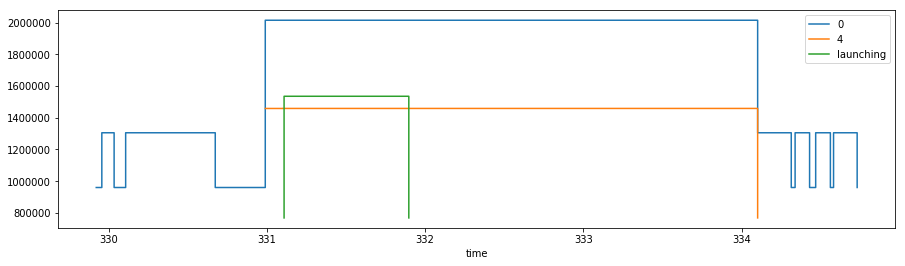

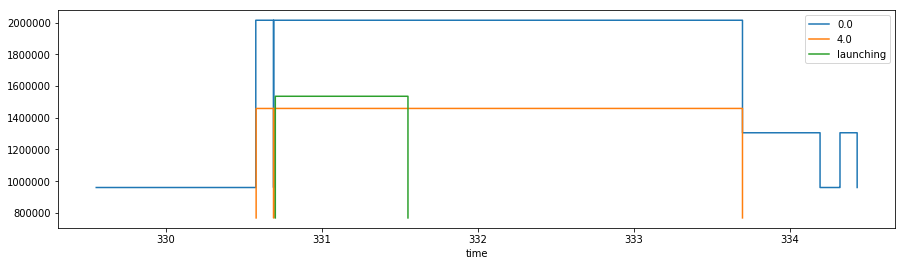

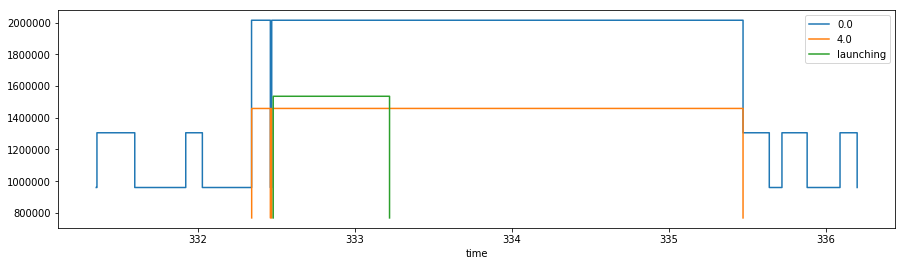

In [30]:
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

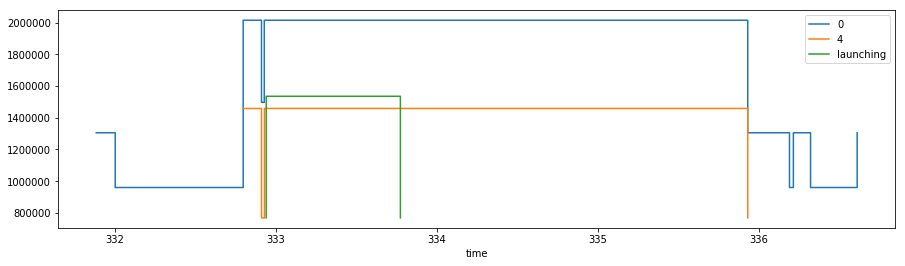

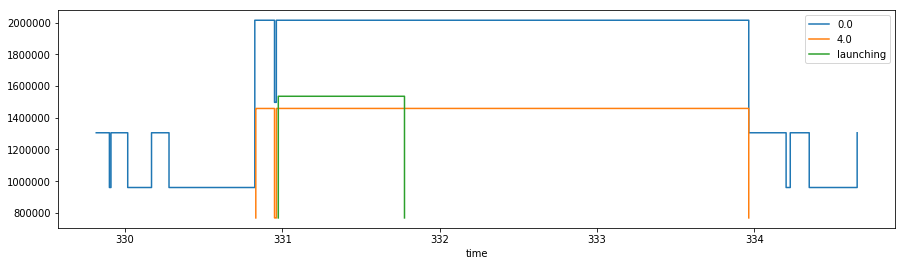

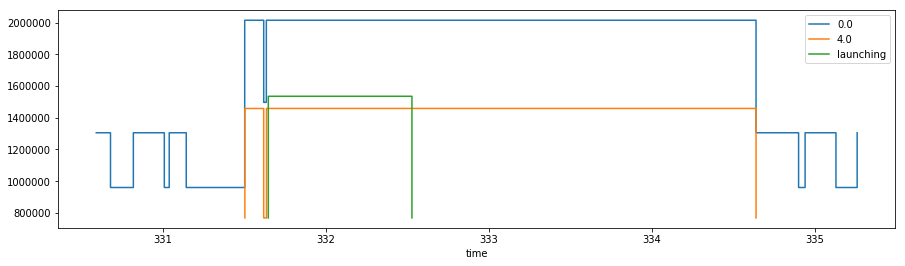

In [31]:
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [62]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

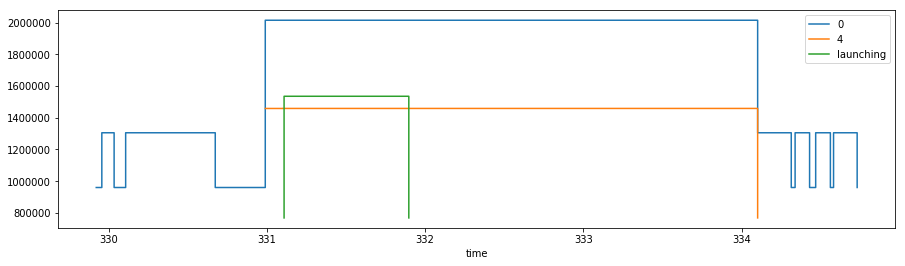

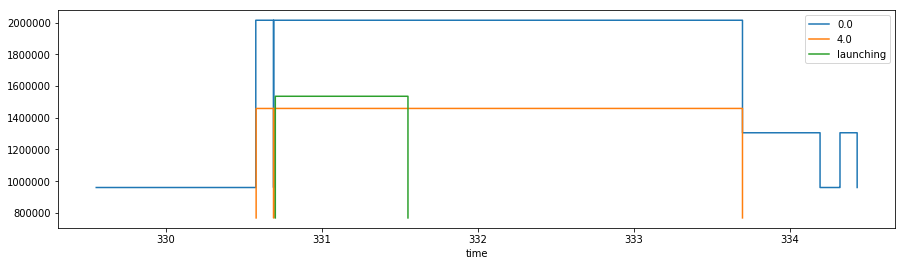

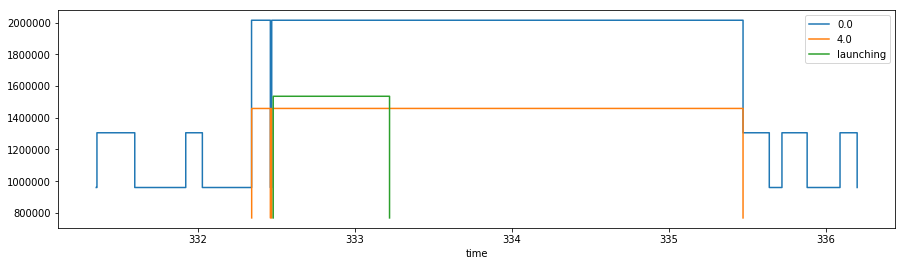

In [30]:
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

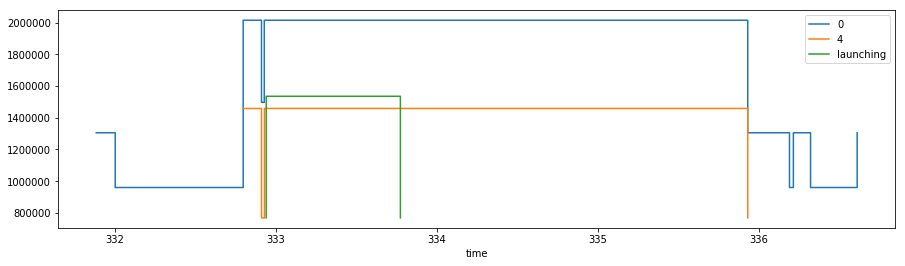

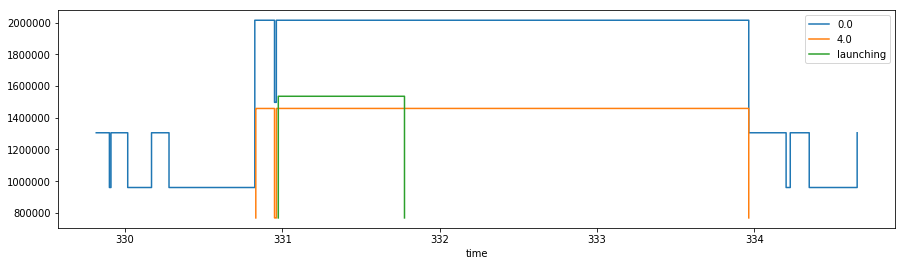

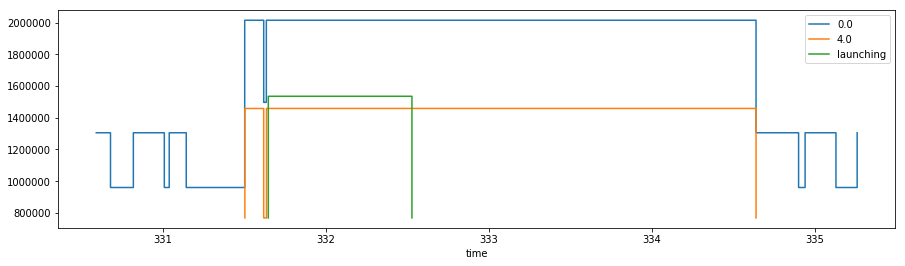

In [31]:
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Lock Contention

In [35]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message,lock_contention,0,5.957,5.475,15.092,36.299,12.967,1.796,0
1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message,lock_contention,0,7.257,3.219,7.065,1.236,15.706,0.000,0
DIFF,lock_contention,0,-1.300,2.256,8.027,35.063,-2.739,1.796,0


In [66]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [37]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message'

,blocking,context,duration,effection,owner,pid,time,type
62,java.lang.Object java.lang.Class.newInstance(...,monitor contention with owner message-t-2 (126...,57.648,O,message-t-2 (12622) at void com.samsung.androi...,12593,331.488932,B
72,void com.google.android.apps.gsa.speech.audio...,monitor contention with owner UserFacingNonBlo...,53.882,O,UserFacingNonBlocking3 (4167) at void com.goog...,4125,331.605612,B
74,void com.google.android.apps.gsa.speech.audio...,monitor contention with owner UserFacingNonBlo...,53.568,O,UserFacingNonBlocking3 (4167) at void com.goog...,4018,331.606058,B
73,int com.google.android.apps.gsa.speech.audio....,monitor contention with owner UserFacingNonBlo...,53.445,O,UserFacingNonBlocking3 (4167) at void android....,4136,331.605848,B
38,boolean com.android.server.wm.WindowProcessCo...,monitor contention with owner android.anim (14...,28.754,O,android.anim (1487) at void com.android.server...,1467,331.255894,B
5,void com.android.server.am.ActivityManagerSer...,monitor contention with owner ActivityManager ...,25.533,O,ActivityManager (1470) at void com.android.ser...,1485,331.113422,B
6,int com.android.server.am.ActivityManagerServ...,monitor contention with owner ActivityManager ...,25.449,O,ActivityManager (1470) at void com.android.ser...,2164,331.113561,B
36,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (14...,22.126,O,android.anim (1487) at void com.android.server...,2164,331.254205,B
16,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1410_7 (2...,10.236,O,Binder:1410_7 (2164) at boolean com.android.se...,1485,331.204967,B
14,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (14...,9.766,O,android.anim (1487) at int com.android.server....,1485,331.194875,B


In [38]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message'

,blocking,context,duration,effection,owner,pid,time,type
57,int com.google.android.apps.gsa.speech.audio....,monitor contention with owner UserFacingNonBlo...,99.222,O,UserFacingNonBlocking2 (4006) at void android....,4010,333.433709,B
59,void com.google.android.apps.gsa.speech.audio...,monitor contention with owner UserFacingNonBlo...,96.222,O,UserFacingNonBlocking2 (4006) at void android....,7084,333.436480,B
58,void com.google.android.apps.gsa.speech.audio...,monitor contention with owner UserFacingNonBlo...,96.172,O,UserFacingNonBlocking2 (4006) at void android....,4105,333.436435,B
239,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1383_1D (...,8.363,O,Binder:1383_1D (6247) at boolean com.android.s...,1817,335.026417,B
238,int com.android.server.am.ActivityManagerServ...,monitor contention with owner Binder:1383_1D (...,7.866,O,Binder:1383_1D (6247) at boolean com.android.s...,1383,335.026012,B
42,void com.android.server.wm.ActivityTaskManage...,monitor contention with owner Binder:1383_4 (2...,7.848,O,Binder:1383_4 (2003) at void com.android.serve...,1443,333.179593,B
241,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1383_C (3...,7.278,O,Binder:1383_C (3140) at int com.android.server...,1817,335.034877,B
237,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1383_1D (...,5.623,O,Binder:1383_1D (6247) at boolean com.android.s...,1414,335.025475,B
51,android.content.IContentProvider android.app....,monitor contention with owner AsyncTask #1 (11...,4.925,O,AsyncTask #1 (11413) at boolean android.os.Bin...,11402,333.380734,B
22,void com.android.server.wm.ActivityMetricsLog...,monitor contention with owner Binder:1383_2 (1...,4.501,O,Binder:1383_2 (1403) at boolean com.android.se...,1443,333.007703,B


Sum of the lock contention's duration. The durations could be duplicated.

In [39]:
display(group1.title)
display(df1['duration'].sum())

u'1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message'

440.97199999976056

In [40]:
display(group2.title)
display(df2['duration'].sum())

u'1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message'

453.50699999954713

Liminated the lock contentions by owners.

In [41]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'1ZAE_1ZAEFSLC_QOStest_200204_200204_101354_message'

,owner
"Thread-8 (12647) at void android.content.res.AssetManager.applyStyle(long, int, int, android.content.res.XmlBlock$Parser, int[], long, long)(AssetManager.java:1113)",13
"main (12593) at void android.content.res.AssetManager.applyStyle(long, int, int, android.content.res.XmlBlock$Parser, int[], long, long)(AssetManager.java:1113)",13
"main (12593) at boolean android.content.res.AssetManager.getResourceValue(int, int, android.util.TypedValue, boolean)(AssetManager.java:555)",11
"main (12593) at android.content.res.XmlBlock android.content.res.AssetManager.openXmlBlockAsset(int, java.lang.String)(AssetManager.java:1090)",7
"message-t-2 (12622) at boolean android.content.res.AssetManager.getResourceValue(int, int, android.util.TypedValue, boolean)(AssetManager.java:555)",5
android.anim (1487) at void com.android.server.wm.InputMonitor$1.run()(InputMonitor.java:126),4
"Binder:1410_7 (2164) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2249)",4
"Binder:1410_C (3272) at int com.android.server.pm.PackageManagerService.checkUidPermission(java.lang.String, int)(PackageManagerService.java:6682)",4
android.anim (1487) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),4
"Binder:1410_1A (4197) at int com.android.server.pm.PackageManagerService.checkUidPermission(java.lang.String, int)(PackageManagerService.java:6682)",4


In [42]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'1ZAE_1ZAEVTAC_QOStest_200204_200204_105858_message'

,owner
"main (11375) at void android.content.res.AssetManager.applyStyle(long, int, int, android.content.res.XmlBlock$Parser, int[], long, long)(AssetManager.java:1113)",8
"Thread-7 (11425) at void android.content.res.AssetManager.applyStyle(long, int, int, android.content.res.XmlBlock$Parser, int[], long, long)(AssetManager.java:1113)",8
"Thread-7 (11425) at android.content.res.TypedArray android.content.res.ResourcesImpl$ThemeImpl.obtainStyledAttributes(android.content.res.Resources$Theme, android.util.AttributeSet, int[], int, int)(ResourcesImpl.java:1447)",8
Binder:1383_1D (6247) at boolean com.android.server.am.ActivityManagerService.unbindService(android.app.IServiceConnection)(ActivityManagerService.java:16153),5
"main (11375) at android.content.res.TypedArray android.content.res.ResourcesImpl$ThemeImpl.obtainStyledAttributes(android.content.res.Resources$Theme, android.util.AttributeSet, int[], int, int)(ResourcesImpl.java:1447)",5
"Binder:1383_4 (2003) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2249)",4
android.anim (1448) at void com.android.server.wm.InputMonitor$1.run()(InputMonitor.java:126),4
"main (11375) at android.content.res.XmlBlock android.content.res.AssetManager.openXmlBlockAsset(int, java.lang.String)(AssetManager.java:1090)",4
"Binder:1383_4 (2003) at void com.android.server.am.ActivityManagerService.attachApplication(android.app.IApplicationThread, long)(ActivityManagerService.java:6166)",3
"Binder:1383_2 (1403) at void com.android.server.pm.PackageManagerService$PackageManagerInternalImpl.notifyPackageUse(java.lang.String, int)(PackageManagerService.java:30565)",3


Text(0,0.5,'weight')

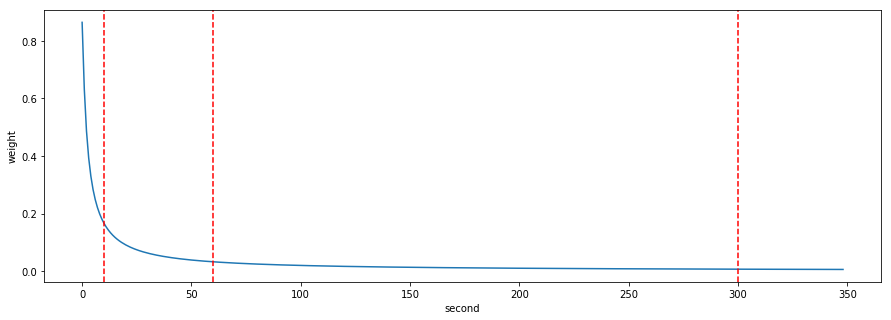

In [73]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')